# Task 2

## Import Libraries

In [1]:
import sys
sys.path.append('../src')

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from tqdm import tqdm

from environment_gym import TrafficEnvironment
from task2_environment import CustomTrafficEnvironment
from task2_agents import RuleBasedAgent, TemporalDifference
from visualization import extract_timesteps_from_json, create_visualization_from_cached_data

seed = 2024

c:\Users\danie\OneDrive - Singapore Management University\SMU Singapore\Academics\Aug 2024\CS609_ReinforcementLearning\Project\LaneSwitchRL-Simulation\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Rule-Based Agent

### Fastest Adjacent Lane

In [6]:
# Create the environment
env = CustomTrafficEnvironment(max_time_steps=10000, logging_enabled=False, seed=seed)
# Evaluate each strategy
rewards_dict = {}
timesteps_dict = {}

agent = RuleBasedAgent(env=env, strategy='fastest_adjacent')
# episode_rewards, checkpoint_rewards, timesteps_to_termination = evaluate_agent(agent, env)
all_episode_rewards, all_timesteps = agent.evaluate_agent(num_episodes=500)
rewards_dict['Fastest Adjacent Lane Agent'] = all_episode_rewards
timesteps_dict['Fastest Adjacent Lane Agent'] = all_timesteps
# env.logger.info("\n"*5)

print(f'Average cumulative rewards for Fastest Adjacent Lane strategy: {round(np.mean(rewards_dict['Fastest Adjacent Lane Agent']))}')
print(f'Average timesteps to termination for Fastest Adjacent Lane strategy: {round(np.mean(timesteps_dict["Fastest Adjacent Lane Agent"]))}')

100%|██████████| 500/500 [00:32<00:00, 15.25it/s]

Truncated episodes: 144
Average cumulative rewards for Fastest Adjacent Lane strategy: -8246
Average timesteps to termination for Fastest Adjacent Lane strategy: 359


### Same Lane

In [7]:
# Create the environment
env = CustomTrafficEnvironment(max_time_steps=10000, logging_enabled=False, seed=seed)

for i in range(5):
    env.logger.info(f"Evaluating Agent {i+1}")
    agent = RuleBasedAgent(env=env, strategy='stay')
    all_episode_rewards, all_timesteps = agent.evaluate_agent(num_episodes=500, starting_lane=i+1)
    rewards_dict[f'Same Lane Agent {i+1}'] = all_episode_rewards
    timesteps_dict[f'Same Lane Agent {i+1}'] = all_timesteps
    
    print(f'Average cumulative rewards for Same Lane Agent {i+1}: {round(np.mean(all_episode_rewards))}')
    print(f'Average timesteps to termination for Same Lane Agent {i+1}: {round(np.mean(all_timesteps))}')
    print('\n')

100%|██████████| 500/500 [00:41<00:00, 12.18it/s]


Truncated episodes: 181
Average cumulative rewards for Same Lane Agent 1: -11523
Average timesteps to termination for Same Lane Agent 1: 470




100%|██████████| 500/500 [00:40<00:00, 12.44it/s]


Truncated episodes: 184
Average cumulative rewards for Same Lane Agent 2: -10046
Average timesteps to termination for Same Lane Agent 2: 469




100%|██████████| 500/500 [00:38<00:00, 13.11it/s]


Truncated episodes: 177
Average cumulative rewards for Same Lane Agent 3: -9666
Average timesteps to termination for Same Lane Agent 3: 455




100%|██████████| 500/500 [00:39<00:00, 12.80it/s]


Truncated episodes: 180
Average cumulative rewards for Same Lane Agent 4: -10260
Average timesteps to termination for Same Lane Agent 4: 473




100%|██████████| 500/500 [00:40<00:00, 12.33it/s]

Truncated episodes: 183
Average cumulative rewards for Same Lane Agent 5: -12317
Average timesteps to termination for Same Lane Agent 5: 481




## Value-based Agent

### Training

{'alpha': 0.00192124204435242, 'gamma': 0.2797587807241957, 'epsilon_min': 0.021845516948892266, 'lambd': 0.49017176264381024}

100%|██████████| 500/500 [15:50<00:00,  1.90s/it]


Early Termination Count: 204
Sum of total rewards = -6156598.800000002
Average total reward per episode = -12313.197600000001
Average steps per episode = 464.3310810810811


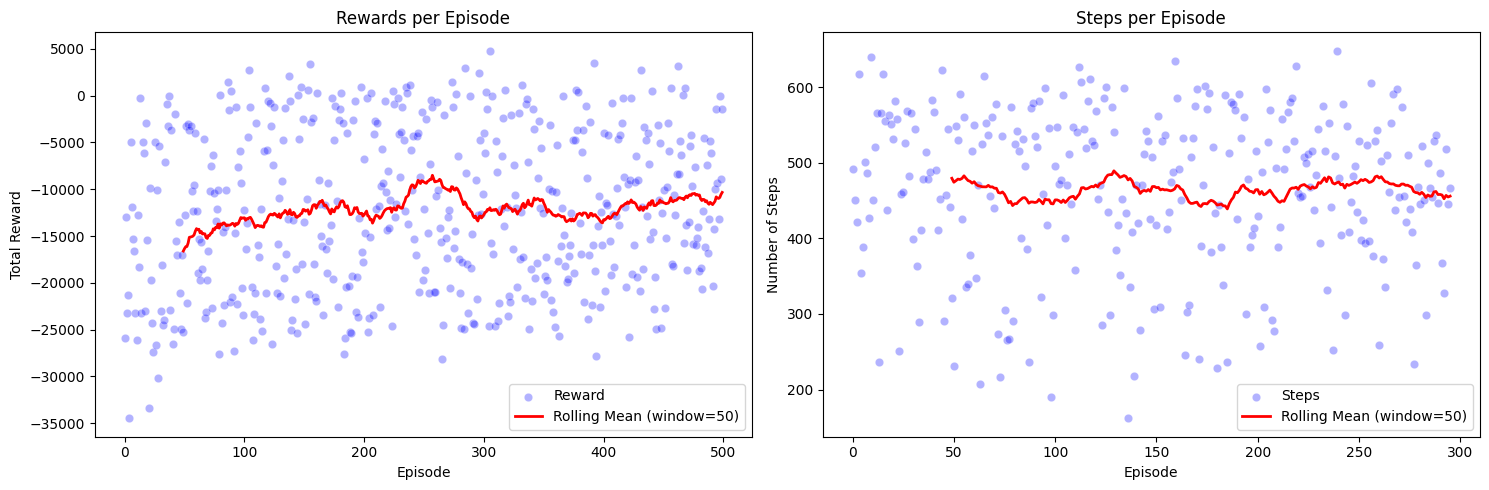

In [4]:
# Create the environment
env = CustomTrafficEnvironment(max_time_steps=10000, logging_enabled=False, seed=seed)

td_lambda = TemporalDifference(env, oiv = 0.1, alpha=1.92e-3, epsilon=1.0, lambd=0.49, gamma=0.28, epsilon_decay=0.9999, epsilon_min=0.022)
total_reward_list, total_steps_list = td_lambda.train(num_episodes = 500, on_policy = False, save_model = False)
total_rew = sum(total_reward_list)
avg_rew = np.mean(total_reward_list)
avg_steps = np.mean(total_steps_list)

print(f'Sum of total rewards = {total_rew}')
print(f'Average total reward per episode = {avg_rew}')
print(f'Average steps per episode = {avg_steps}')

# plot training metrics
td_lambda.plot_training_metrics(window_size=50)
plt.show()

### Analysis

In [5]:
print(f'Filled State Space: {len(td_lambda.Q)}')

Filled State Space: 3207


State Space Size = 10 x 10 x 10 (Clearance Rates) x 5 (Risk Factor) x 3 (Actions) = 15,000

In [6]:
q_df = td_lambda.q_table_to_dataframe()
q_df.head()

,Current Lane Rate,Left Lane Rate,Right Lane Rate,Risk Factor,Left,Stay,Right
0,5,0,5,0,-1.218330,37.295031,0.912509
1,5,5,4,0,0.280931,2.996587,0.134972
2,5,0,4,0,-0.957550,29.659747,0.221033
3,5,0,6,0,-0.177903,22.576233,0.680582
4,5,0,6,1,0.036300,1.088888,0.100000


In [7]:
lanes = ['Current', 'Left', 'Right']
for fast_lane in lanes:
    other_lanes = lanes.copy()
    other_lanes.remove(fast_lane)
    total = q_df.loc[((q_df[f'{fast_lane} Lane Rate'] > q_df[f'{other_lanes[0]} Lane Rate']) & (q_df[f'{fast_lane} Lane Rate'] > q_df[f'{other_lanes[1]} Lane Rate'])) & (q_df['Risk Factor'] < 5)].shape[0]
    rate = q_df.loc[((q_df[f'{fast_lane} Lane Rate'] > q_df[f'{other_lanes[0]} Lane Rate']) & (q_df[f'{fast_lane} Lane Rate'] > q_df[f'{other_lanes[1]} Lane Rate'])) & (q_df['Risk Factor'] < 5) \
    & ((q_df[f'{fast_lane if fast_lane != 'Current' else 'Stay'}'] > q_df[f'{other_lanes[0] if other_lanes[0] != 'Current' else 'Stay'}']) \
        & (q_df[f'{fast_lane if fast_lane != 'Current' else 'Stay'}'] > q_df[f'{other_lanes[1] if other_lanes[1] != 'Current' else 'Stay'}']))].shape[0]
    rate = rate/q_df.shape[0]
    print(f"Number of cases where the {fast_lane} lane is fastest and has the highest value for low risk: {rate*100}%")

Number of cases where the Current lane is fastest and has the highest value for low risk: 20.049890863735577%
Number of cases where the Left lane is fastest and has the highest value for low risk: 4.490177736202058%
Number of cases where the Right lane is fastest and has the highest value for low risk: 3.8041783598378545%


### Evaluation

In [6]:
td_lambda.Env.enable_logging()

In [5]:
# Evaluate the agent in inference mode
all_rewards, all_steps, log_file = td_lambda.evaluate(num_episodes=500)

# Print the results
print(f"Average cumulative rewards for TD-Lambda Agent: {round(np.mean(all_rewards))}")
print(f"Average timesteps to termination for TD-Lambda Agent: {round(np.mean(all_steps))}")

100%|██████████| 500/500 [00:45<00:00, 11.04it/s]

Early terminations: 189
Average cumulative rewards for TD-Lambda Agent: -10137
Average timesteps to termination for TD-Lambda Agent: 361


In [7]:
td_lambda.Env.disable_logging()

### Visualization

In [8]:
json_path = log_file

extract_timesteps_from_json(json_path)
gif_filename = os.path.basename(json_path).replace('.json', '.gif')

gif_filepath = f'./gifs/task2/{gif_filename}'

create_visualization_from_cached_data(gif_filename=gif_filepath, step_interval=1)

Timesteps data from the first line successfully cached, containing 320 timesteps
GIF saved at ./gifs/task2/test_log_20241106_012844.gif


### Hyperparameter Tuning

In [3]:
episodes = 500
trials = 30
on_policy = False
hyperparameter_space = {
    'alpha': [1e-4, 1e-2],           # Learning rate range (log scale)
    'gamma': [0.1, 0.99],            # Discount factor range
    'epsilon_min': [0.01, 0.1],      # Minimum epsilon range
    'lambd': [0, 0.9]             # Lambda range for eligibility traces
}
env = CustomTrafficEnvironment(max_time_steps=10000, logging_enabled=False, seed=seed)
td_lambda = TemporalDifference(env)
# Run hyperparameter tuning
best_agent, best_params = td_lambda.hyperparameter_tuning(hyperparameter_space=hyperparameter_space, episodes=episodes, n_trials=trials, on_policy=on_policy)

[I 2024-11-06 01:30:58,466] A new study created in memory with name: no-name-cfddac4e-4b8c-4e10-b08c-130a23b316bb
100%|██████████| 500/500 [11:41<00:00,  1.40s/it]
[I 2024-11-06 01:42:40,039] Trial 0 finished with value: -14501.168 and parameters: {'alpha': 0.00013369553960730038, 'gamma': 0.5508399047063363, 'epsilon_min': 0.05336545245221014, 'lambd': 0.16030156070198845}. Best is trial 0 with value: -14501.168.


Early Termination Count: 183
Trial 0: Average Reward = -14501.17


100%|██████████| 500/500 [18:04<00:00,  2.17s/it]
[I 2024-11-06 02:00:45,005] Trial 1 finished with value: -11479.3498 and parameters: {'alpha': 0.00839084899284165, 'gamma': 0.36562021917105747, 'epsilon_min': 0.024975903476890278, 'lambd': 0.7393927506798519}. Best is trial 1 with value: -11479.3498.


Early Termination Count: 175
Trial 1: Average Reward = -11479.35


100%|██████████| 500/500 [20:53<00:00,  2.51s/it]
[I 2024-11-06 02:21:38,027] Trial 2 finished with value: -11556.179199999999 and parameters: {'alpha': 0.0012292760410272225, 'gamma': 0.211732213450754, 'epsilon_min': 0.013896668682229291, 'lambd': 0.6014068888686219}. Best is trial 1 with value: -11479.3498.


Early Termination Count: 189
Trial 2: Average Reward = -11556.18


100%|██████████| 500/500 [22:47<00:00,  2.74s/it]
[I 2024-11-06 02:44:25,839] Trial 3 finished with value: -11822.596599999997 and parameters: {'alpha': 0.0002454642405254573, 'gamma': 0.39188047637974777, 'epsilon_min': 0.029997315037478788, 'lambd': 0.16443304165884037}. Best is trial 1 with value: -11479.3498.


Early Termination Count: 183
Trial 3: Average Reward = -11822.60


100%|██████████| 500/500 [24:00<00:00,  2.88s/it]
[I 2024-11-06 03:08:26,209] Trial 4 finished with value: -12417.054799999998 and parameters: {'alpha': 0.00046340020943997067, 'gamma': 0.11131534417472168, 'epsilon_min': 0.04060464007398542, 'lambd': 0.8818807963203183}. Best is trial 1 with value: -11479.3498.


Early Termination Count: 186
Trial 4: Average Reward = -12417.05


100%|██████████| 500/500 [22:54<00:00,  2.75s/it]
[I 2024-11-06 03:31:20,543] Trial 5 finished with value: -11462.5582 and parameters: {'alpha': 0.006709917527813584, 'gamma': 0.8802582243310468, 'epsilon_min': 0.01279364035882487, 'lambd': 0.6086416821449528}. Best is trial 5 with value: -11462.5582.


Early Termination Count: 175
Trial 5: Average Reward = -11462.56


100%|██████████| 500/500 [23:38<00:00,  2.84s/it]
[I 2024-11-06 03:54:59,378] Trial 6 finished with value: -10169.137399999998 and parameters: {'alpha': 0.0011549893031386836, 'gamma': 0.26379921903652004, 'epsilon_min': 0.022236710858105215, 'lambd': 0.14426472359230533}. Best is trial 6 with value: -10169.137399999998.


Early Termination Count: 179
Trial 6: Average Reward = -10169.14


100%|██████████| 500/500 [25:53<00:00,  3.11s/it]
[I 2024-11-06 04:20:52,651] Trial 7 finished with value: -11564.2954 and parameters: {'alpha': 0.0014965651657249308, 'gamma': 0.7788217178045674, 'epsilon_min': 0.05376746045707848, 'lambd': 0.017852831550551663}. Best is trial 6 with value: -10169.137399999998.


Early Termination Count: 164
Trial 7: Average Reward = -11564.30


100%|██████████| 500/500 [25:54<00:00,  3.11s/it]
[I 2024-11-06 04:46:46,745] Trial 8 finished with value: -10723.203 and parameters: {'alpha': 0.0011531266267461931, 'gamma': 0.41565219041271584, 'epsilon_min': 0.013939628578748928, 'lambd': 0.6275546873444747}. Best is trial 6 with value: -10169.137399999998.


Early Termination Count: 166
Trial 8: Average Reward = -10723.20


100%|██████████| 500/500 [25:11<00:00,  3.02s/it]
[I 2024-11-06 05:11:57,919] Trial 9 finished with value: -10266.319399999998 and parameters: {'alpha': 0.0015119380955352047, 'gamma': 0.50394015494717, 'epsilon_min': 0.03367387110294507, 'lambd': 0.8552907305724308}. Best is trial 6 with value: -10169.137399999998.


Early Termination Count: 174
Trial 9: Average Reward = -10266.32


100%|██████████| 500/500 [25:59<00:00,  3.12s/it]
[I 2024-11-06 05:37:57,538] Trial 10 finished with value: -10884.151 and parameters: {'alpha': 0.0037079248418845404, 'gamma': 0.6461926916131537, 'epsilon_min': 0.0913470082085469, 'lambd': 0.3448951335903483}. Best is trial 6 with value: -10169.137399999998.


Early Termination Count: 182
Trial 10: Average Reward = -10884.15


100%|██████████| 500/500 [26:42<00:00,  3.21s/it]
[I 2024-11-06 06:04:40,111] Trial 11 finished with value: -10398.888799999999 and parameters: {'alpha': 0.0026616844278862786, 'gamma': 0.2734804421912678, 'epsilon_min': 0.0383237376662616, 'lambd': 0.36200241683791845}. Best is trial 6 with value: -10169.137399999998.


Early Termination Count: 173
Trial 11: Average Reward = -10398.89


100%|██████████| 500/500 [26:06<00:00,  3.13s/it]
[I 2024-11-06 06:30:46,660] Trial 12 finished with value: -10901.681799999997 and parameters: {'alpha': 0.00035721231806024, 'gamma': 0.5618849109869417, 'epsilon_min': 0.07156835735681713, 'lambd': 0.8822948254166254}. Best is trial 6 with value: -10169.137399999998.


Early Termination Count: 195
Trial 12: Average Reward = -10901.68


100%|██████████| 500/500 [27:49<00:00,  3.34s/it]
[I 2024-11-06 06:58:36,471] Trial 13 finished with value: -11205.552800000001 and parameters: {'alpha': 0.0006330843442146032, 'gamma': 0.7110213217517362, 'epsilon_min': 0.03068533107936386, 'lambd': 0.4602345037719309}. Best is trial 6 with value: -10169.137399999998.


Early Termination Count: 165
Trial 13: Average Reward = -11205.55


100%|██████████| 500/500 [27:48<00:00,  3.34s/it]
[I 2024-11-06 07:26:25,358] Trial 14 finished with value: -10796.026 and parameters: {'alpha': 0.0025488789475054, 'gamma': 0.47374775944547, 'epsilon_min': 0.06914355094644056, 'lambd': 0.24741909737291445}. Best is trial 6 with value: -10169.137399999998.


Early Termination Count: 150
Trial 14: Average Reward = -10796.03


100%|██████████| 500/500 [25:58<00:00,  3.12s/it]
[I 2024-11-06 07:52:24,045] Trial 15 finished with value: -10871.125999999998 and parameters: {'alpha': 0.0007063773895675594, 'gamma': 0.9834487283031104, 'epsilon_min': 0.04303642153917793, 'lambd': 0.01698969474031653}. Best is trial 6 with value: -10169.137399999998.


Early Termination Count: 176
Trial 15: Average Reward = -10871.13


100%|██████████| 500/500 [24:58<00:00,  3.00s/it]
[I 2024-11-06 08:17:22,881] Trial 16 finished with value: -10140.2358 and parameters: {'alpha': 0.00192124204435242, 'gamma': 0.2797587807241957, 'epsilon_min': 0.021845516948892266, 'lambd': 0.49017176264381024}. Best is trial 16 with value: -10140.2358.


Early Termination Count: 174
Trial 16: Average Reward = -10140.24


100%|██████████| 500/500 [24:55<00:00,  2.99s/it]
[I 2024-11-06 08:42:18,267] Trial 17 finished with value: -10621.23 and parameters: {'alpha': 0.003859787284148293, 'gamma': 0.11266718085139682, 'epsilon_min': 0.02320622330234573, 'lambd': 0.48007132752708126}. Best is trial 16 with value: -10140.2358.


Early Termination Count: 167
Trial 17: Average Reward = -10621.23


100%|██████████| 500/500 [25:00<00:00,  3.00s/it]
[I 2024-11-06 09:07:18,819] Trial 18 finished with value: -11166.279399999998 and parameters: {'alpha': 0.002289081021677856, 'gamma': 0.2615585708705315, 'epsilon_min': 0.06862089778124036, 'lambd': 0.34035029036640385}. Best is trial 16 with value: -10140.2358.


Early Termination Count: 181
Trial 18: Average Reward = -11166.28


100%|██████████| 500/500 [26:38<00:00,  3.20s/it]
[I 2024-11-06 09:33:57,155] Trial 19 finished with value: -10357.345399999998 and parameters: {'alpha': 0.0008567326888334176, 'gamma': 0.31344577312022326, 'epsilon_min': 0.021709941735471763, 'lambd': 0.5323041515795106}. Best is trial 16 with value: -10140.2358.


Early Termination Count: 185
Trial 19: Average Reward = -10357.35


100%|██████████| 500/500 [24:52<00:00,  2.99s/it]
[I 2024-11-06 09:58:49,702] Trial 20 finished with value: -10353.212 and parameters: {'alpha': 0.005150935330243716, 'gamma': 0.15530856706880852, 'epsilon_min': 0.045283801444839664, 'lambd': 0.12670077450541747}. Best is trial 16 with value: -10140.2358.


Early Termination Count: 188
Trial 20: Average Reward = -10353.21


100%|██████████| 500/500 [27:50<00:00,  3.34s/it]
[I 2024-11-06 10:26:40,168] Trial 21 finished with value: -10986.927599999999 and parameters: {'alpha': 0.0013724227271120987, 'gamma': 0.4595914432198912, 'epsilon_min': 0.03468914628404262, 'lambd': 0.8112464980205946}. Best is trial 16 with value: -10140.2358.


Early Termination Count: 164
Trial 21: Average Reward = -10986.93


 34%|███▍      | 169/500 [08:47<17:12,  3.12s/it]
[W 2024-11-06 10:35:27,409] Trial 22 failed with parameters: {'alpha': 0.0018793319169921005, 'gamma': 0.20358486858009844, 'epsilon_min': 0.020233910795687426, 'lambd': 0.693720813789415} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\danie\OneDrive - Singapore Management University\SMU Singapore\Academics\Aug 2024\CS609_ReinforcementLearning\Project\LaneSwitchRL-Simulation\.venv\Lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "c:\Users\danie\OneDrive - Singapore Management University\SMU Singapore\Academics\Aug 2024\CS609_ReinforcementLearning\Project\LaneSwitchRL-Simulation\notebooks\../src\task2_agents.py", line 461, in objective
    # Train the agent with the current hyperparameters
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\danie\OneDrive - Singapor

KeyboardInterrupt: 